In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
!uv pip install -qU duckduckgo-search langchain-community ddgs

In [ ]:
# llm 설정
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [4]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

In [5]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together"""
    return a * b

In [6]:
# vector store 생성
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="real_estate_tax",
    persist_directory="./real_estate_tax_collection",
    embedding_function=embeddings
)

retriver = vector_store.as_retriever(search_kwargs={"k": 3})

In [7]:
from langchain_core.tools import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriver, 
    "real_estate_tax_retriever",
    "Real Estate Tax Retriever"
)

In [8]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search, retriever_tool]

tool_node = ToolNode(tool_list)
llm_with_tools = llm.bind_tools(tool_list)

In [9]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [10]:
def agent(state: MessagesState):
    message = state['messages']
    response = llm_with_tools.invoke(message)
    return {'messages': [response]}

In [11]:
from typing import Literal

def should_continue(state: MessagesState) -> Literal['tools', 'end']:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'tools'
    else:
        return 'end'
        

In [12]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [13]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent', 
    should_continue,
    {
        'tools': 'tools',
        'end': END
    }
)
graph_builder.add_edge('tools', 'agent')

In [14]:
graph = graph_builder.compile()

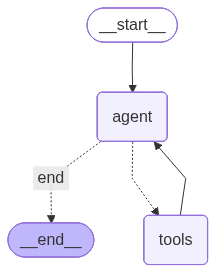

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
from langchain_core.messages import HumanMessage


messages = [HumanMessage(content="집이 15억일 때 종합부동산세를 계산해줄 수 있나요?")]

In [17]:
for chunk in graph.stream({'messages': messages}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

집이 15억일 때 종합부동산세를 계산해줄 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (call_2V2xPILmhTwkSZRcgIqNUY8Y)
 Call ID: call_2V2xPILmhTwkSZRcgIqNUY8Y
  Args:
    query: 15억 종합부동산세
================================= Tool Message =================================
Name: real_estate_tax_retriever

| 45억원 초과 | 8천250만원+(45억원을 초과하는 금액의 1천분의 30) |
② 삭제<2008. 12. 26.>
③종합합산과세대상인 토지의 과세표준 금액에 대하여 해당 과세대상 토지의 토지분 재산세로 부과된 세액(「지방세법」 제111조제3항에 따라 가감조정된 세율이 적용된 경우에는 그 세율이 적용된 세액, 같은 법 제122조제1따라 세부담 상한률 적용받은 경우에는 그 상한률 적용받은 세액을 말한다)은 토지분 종합합산세액에서 이를 공제한다.
신설 2005. 12. 31, 2008. 12. 26, 2010. 3. 31.>
④별도합산과세대상인 토지에 대한 종합부동산세의 세액은 과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “토지분 별도합산세액”이라 한다)으로 한다.<개정 2008. 12. 26.>
| 과세표준  | 세율  |
|---|---|
| 200억원 이하 | 1천분의 5 |
| 200억원 초과 400억원 이하 | 1억원+(200억원을 초과하는 금액의 1천분의 10) |
| 400억원 초과 | 2억원+(400억원을 초과하는 금액의 1천분의 12) |
⑤ 삭제<